# Sensor Data Processing: Building a Simple Step Counter
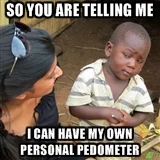
## Introduction

In this session, we will explore some of the steps for processing sensor data with python libraries, focusing on building a simple step counter as an illustrative example. This notebook has been adapted from https://aosabook.org/en/500L/a-pedometer-in-the-real-world.html

Remember to first save a copy of this notebook by clicking File > Save a copy in drive to start modifying it.

### Learning Outcomes

By the end of this session, you will:

1. Understand the basics of sensor data processing.
2. Gain practical experience with Python, scipy, numpy and Jupyter notebooks.
3. Learn how to extract meaningful insights from accelerometer data to count steps.
4. Explore key concepts such as signal filtering, fast fourier transform, peak detection and basic data visualization.

### Overview

The ability to process sensor data is crucial in various fields, including health monitoring, sports analytics, and Internet of Things (IoT) applications. In this notebook, we will walk through the process of creating a step counter using accelerometer data. Accelerometers measure acceleration, and by analyzing this data, we can infer the number of steps a person takes.

Here's a brief overview of what we'll cover:

1. **Setup and Data Collection:**
   - Import necessary libraries.
   - Simulate or load accelerometer data.

2. **Data Preprocessing:**
   - Clean and prepare the raw data.
   - Apply filtering techniques to remove noise.

3. **Feature engineering:**
   - Identify peaks as relevant features related to step detection.

4. **Step Counting Algorithm:**
   - Implement a basic step counting algorithm.

5. **Visualization:**
   - Visualize the processed data and step count.

You'll have the opportunity to apply your Python programming skills, gain a deeper understanding of filtering, and witness the transformation of raw sensor data into valuable information.

Let's dive in!

## Understanding accelerometer data
Using your phone and the Sensor Toolkit Application, first see the accelerometer data. Put your phone in the table and plot what you see.
Then, move your phone vertically and maintain there. Finally, put your phone horizontally. Notice the value for each axis. Rotate your phone in various axis, keeping it still for a few seconds at each position.
Draw the axis of your phone.

## Setup and Data Collection
For this tutorial, we are using an open dataset from the Oxford step counter project (https://oxford-step-counter.github.io). The dataset contains accelerometer data collected from a smartphone in various locations while walking. The data is sampled at 400Hz and contains 4 columns: timestamp, id, and x, y, z accelerometer readings. The timestamp is in nanoseconds, and the id is a unique identifier for the sensor.
The x, y, z columns contain the accelerometer readings in m/s^2.
We will use the wget command to download the dataset. We are downloading the back pocket data from the Pixel_Jamie_Hard_BackPocket_1 folder. The data is stored in a csv file. We will use the pandas library to read the csv file and plot the data.

### Import Libraries

In [5]:
import pandas as pd
from tqdm.auto import tqdm
import numpy as np


### wget

To download the data we will use the wget command. wget is a command-line utility for downloading files from the web. It supports downloading files using various protocols, including HTTP, HTTPS, and FTP.  The basic syntax of wget is as follows:
wget [options] [URL]

In a Jupyter notebook, you can use a code cell with the ! prefix to run the shell command.

### Download Data
In the next cell type
```
!wget -P ./ "https://raw.githubusercontent.com/Oxford-step-counter/DataSet/master/optimisation/data/Pixel_Jamie_Hard_BackPocket_1/accelerometer.csv" -O "backpocket-accelerometer.csv"
```
to dowload the file. Notice the -O option to rename the downloaded file. Verify the download has completed.

In [6]:
#TODO
!wget -P ./ "https://raw.githubusercontent.com/Oxford-step-counter/DataSet/master/optimisation/data/Pixel_Jamie_Hard_BackPocket_1/accelerometer.csv" -O "backpocket-accelerometer.csv"


--2026-01-28 08:59:34--  https://raw.githubusercontent.com/Oxford-step-counter/DataSet/master/optimisation/data/Pixel_Jamie_Hard_BackPocket_1/accelerometer.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2934254 (2.8M) [text/plain]
Saving to: ‘backpocket-accelerometer.csv’

ckpocket-accelerome 100%[===================>]   2.80M  --.-KB/s    in 0.07s   

2026-01-28 08:59:34 (41.6 MB/s) - ‘backpocket-accelerometer.csv’ saved [2934254/2934254]



### Questions
Throughout the notebook you will find some questions for you to answer. Create a new cell to write your answers. You can double click on the cell to edit it. You can also use markdown to format your answers. For more information on markdown, see https://www.markdownguide.org/basic-syntax/

1. What is the sampling frequency of the data?
2. What is the meaning of the -O option in the wget command?
3. Where is the file stored? What is the name of the file?

In [7]:
import pandas as pd

# load the data
# df = pd.read_csv("backpocket-accelerometer.csv", header=None)
# first column is timestamps in microseconds
# timestamps = df[0].values

# ACCEL_CSV_PATH = "backpocket-accelerometer.csv"
ACCEL_CSV_PATH = "achal_patel_walks_50_steps.csv"
# load the data
df = pd.read_csv(ACCEL_CSV_PATH)

# first column is timestamps in seconds
timestamps = pd.to_numeric(df.iloc[:, 0], errors="coerce").values

# compute differences between consecutive timestamps
dt = timestamps[1:] - timestamps[:-1]

# convert from microseconds to seconds
dt_sec = dt / 1e6

# average sampling period
avg_dt = dt_sec.mean()

# sampling frequency
fs = 1 / avg_dt
print(f"Sampling frequency: {fs:.2f} Hz")


Sampling frequency: 423105800.14 Hz







#### Your answers go here (double click here)

1. 0.41 Hz

2. The -O option allows you to rename the downloaded file

3. Saving to: root ‘backpocket-accelerometer.csv’







### Read Data
Now that we have downloaded the data, we can read it using the pandas library. Pandas is a Python library for data manipulation and analysis. It provides fast, flexible, and expressive data structures designed to make working with structured data intuitive. We will use the read_csv function to read the csv file. The read_csv function takes the path to the csv file as an argument. We will also specify the column names using the names argument. The names argument takes a list of column names. We will also specify the index_col argument to False. This will prevent pandas from using the first column as the index. We will also use the head function to display the first few rows of the data.

In [8]:


import numpy as np
import pandas as pd

def load_accel_csv(path: str) -> pd.DataFrame:
    """Load an accelerometer CSV and return the *notebook's expected schema*:
    columns: ['timestamp','id','x','y','z'] where timestamp is integer nanoseconds.

    Supports:
    - Oxford backpocket format (no header): timestamp(ns), id, x, y, z
    - Your exported format with header like: Time (s), Acceleration x/y/z (m/s^2)
    """

    # First, decide whether the file has a header.
    preview = pd.read_csv(path, header=None, nrows=5)
    looks_headerless_numeric = pd.to_numeric(preview.iloc[:, 0], errors="coerce").notna().all()

    if looks_headerless_numeric and preview.shape[1] >= 4:
        raw = pd.read_csv(path, header=None)
        # Oxford backpocket is exactly 5 columns.
        if raw.shape[1] >= 5:
            raw = raw.iloc[:, :5]
            raw.columns = ["timestamp", "id", "x", "y", "z"]
            # enforce numeric
            for c in ["timestamp", "id", "x", "y", "z"]:
                raw[c] = pd.to_numeric(raw[c], errors="coerce")
            return raw.dropna(subset=["timestamp", "x", "y", "z"]).reset_index(drop=True)

    # Otherwise assume a header row exists
    raw = pd.read_csv(path)

    # Common column-name variants -> expected names
    cols = list(raw.columns)

    def find_col(candidates):
        for c in candidates:
            if c in cols:
                return c
        return None

    time_col = find_col(["Time (s)", "time", "Time", "timestamp", "Timestamp", "t"])
    ax_col = find_col(["Acceleration x (m/s^2)", "acc_x", "ax", "x", "Accel X", "AccelerationX"])
    ay_col = find_col(["Acceleration y (m/s^2)", "acc_y", "ay", "y", "Accel Y", "AccelerationY"])
    az_col = find_col(["Acceleration z (m/s^2)", "acc_z", "az", "z", "Accel Z", "AccelerationZ"])

    if time_col is None or ax_col is None or ay_col is None or az_col is None:
        raise ValueError(
            f"Could not auto-map columns in {path}. Found columns: {cols}. "
            "Update the candidate lists in load_accel_csv() to match your file."
        )

    # Build standardized dataframe
    out = pd.DataFrame()

    t = pd.to_numeric(raw[time_col], errors="coerce")
    x = pd.to_numeric(raw[ax_col], errors="coerce")
    y = pd.to_numeric(raw[ay_col], errors="coerce")
    z = pd.to_numeric(raw[az_col], errors="coerce")

    # If time is in seconds (common for exports), convert to integer nanoseconds.
    # Heuristic: if values are small (<1e10), treat as seconds.
    if t.dropna().median() < 1e10:
        ts_ns = (t * 1e9).round().astype("Int64")
    else:
        # already large epoch-like timestamps; assume nanoseconds
        ts_ns = t.round().astype("Int64")

    # Heuristic unit fix: if the magnitude is around 9-10, it's likely m/s^2; convert to g.
    # (Oxford backpocket data is in g.)
    mag = np.nanmedian(np.sqrt(x.to_numpy() ** 2 + y.to_numpy() ** 2 + z.to_numpy() ** 2))
    if mag > 4.0:  # ~9.8 m/s^2 gravity
        x, y, z = x / 9.80665, y / 9.80665, z / 9.80665

    out["timestamp"] = ts_ns.astype("int64")
    out["id"] = 0
    out["x"] = x
    out["y"] = y
    out["z"] = z

    return out.dropna(subset=["timestamp", "x", "y", "z"]).reset_index(drop=True)


# read data (everything else in the notebook can stay unchanged)
df = load_accel_csv(ACCEL_CSV_PATH)

# ---- derived globals (avoid hard-coded 400Hz assumptions) ----
# df['timestamp'] is expected to be integer nanoseconds at this point.
_dt_ns = pd.to_numeric(df['timestamp'], errors="coerce").diff().median()
FS = float(1e9 / _dt_ns) if pd.notna(_dt_ns) and _dt_ns != 0 else 400.0
print(f"Detected sampling rate FS ≈ {FS:.2f} Hz")

# Common step-counter tuning values derived from FS
MIN_STEP_SEPARATION_S = 0.25  # seconds (typical max cadence ~4Hz)
MIN_PEAK_DISTANCE_SAMPLES = max(1, int(FS * MIN_STEP_SEPARATION_S))

df.head()

Detected sampling rate FS ≈ 423.10 Hz


,timestamp,id,x,y,z
0,21680845,0,-0.528016,0.686860,0.487756
1,24043918,0,-0.545584,0.690276,0.499956
2,26407355,0,-0.561444,0.692472,0.513620
3,28770845,0,-0.576084,0.696376,0.526308
4,31134282,0,-0.586576,0.699060,0.540216


Let's now plot the data. We will use the plot function from the pandas library to plot the data. The plot function takes the x and y arguments. The x argument specifies the column to use as the x axis, and the y argument specifies the column to use as the y axis. We will also use the figsize argument to specify the size of the figure. The figsize argument takes a tuple of two values. The first value specifies the width of the figure, and the second value specifies the height of the figure.

<Axes: xlabel='timestamp'>

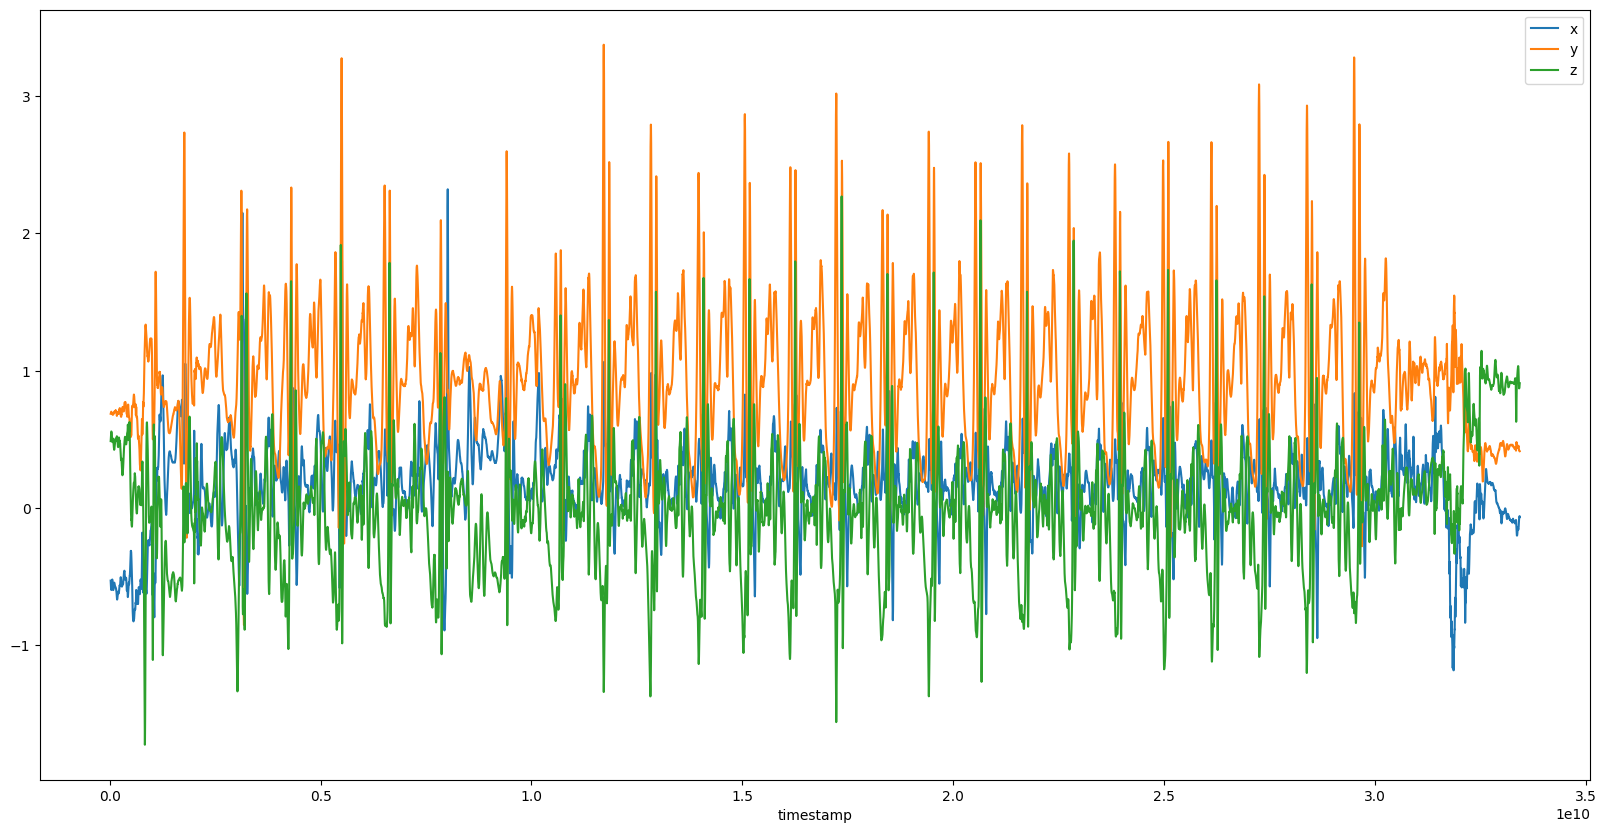

In [9]:
df.plot(x='timestamp', y=['x', 'y', 'z'], figsize=(20,10))

The data is from an accelerometer. "An accelerometer returns a signal in 3-dimensional space. A signal is a set of data points recorded over time. Each component of the signal is a time series representing acceleration in one of the x, y, or z directions. Each point in a time series is the acceleration in that direction at a specific point in time. Acceleration is measured in units of g-force, or g. One g is equal to 9.8 m/s2, the average acceleration due to gravity on Earth." [1]

### Questions
1. What is the meaning of the figsize argument?
2. What is the meaning of the x and y arguments?
3. What value is the y axis moving around? What meaning do you give to this value?





#### Your answers go here (double click here)

1. the size of the plot generated by the df.plot

2. the x and y axis

3. Y is point downward in the direction of the gravity







#### Your answers here

## Data Preprocessing
Now that we have read the data, we can start preprocessing it. Data preprocessing is a crucial step in data analysis. It involves transforming raw data into an understandable format. Data preprocessing is often required to clean the data and prepare it for further analysis. In this section, we will clean the data and apply filtering techniques to remove noise.
First, we will check the sampling rate. The sampling rate is the number of samples per second. It is usually measured in Hertz (Hz). We will use the diff function to calculate the difference between two consecutive timestamps. We will then use the mode function to calculate the most common difference. We will then use the total_seconds function to convert the difference to seconds. We will use the 1/ operator to calculate the sampling rate.


In [10]:
#convert timestamp to datetime with unit nanosecons
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ns')
df.head()

,timestamp,id,x,y,z
0,1970-01-01 00:00:00.021680845,0,-0.528016,0.686860,0.487756
1,1970-01-01 00:00:00.024043918,0,-0.545584,0.690276,0.499956
2,1970-01-01 00:00:00.026407355,0,-0.561444,0.692472,0.513620
3,1970-01-01 00:00:00.028770845,0,-0.576084,0.696376,0.526308
4,1970-01-01 00:00:00.031134282,0,-0.586576,0.699060,0.540216


In [11]:
# get most common difference between two consecutive timestamps
mode_diff = df['timestamp'].diff().mode()[0].total_seconds()
print("Time difference between two samples in seconds : " , mode_diff)
#get sampling rate by taking the inverse of the difference
sampling_rate = 1/mode_diff
print("Sampling rate in Hz: " , sampling_rate)

Time difference between two samples in seconds :  0.002363
Sampling rate in Hz:  423.1908590774439


In [12]:
#get data frequency by taking the difference between two consecutive timestamps and getting the median - just checking if there are too many outliers
1/df['timestamp'].diff().median().total_seconds()


423.1908590774439

## Frequency Domain Representation
We can also obtain a frequency domain representation of the data. The frequency domain representation of a signal is a representation of the signal as a function of frequency. It provides information about the frequency components of the signal. We will use the fftpack library to obtain the frequency domain representation of the data. Let's first import the libraries we will be using

In [13]:
import numpy as np
from scipy import fftpack
import matplotlib.pyplot as plt

### Plotting the frequency domain representation of the data
To plot the frequency domain representation of the data, we will use the fft function from the fftpack library. The fft function takes the data as an argument. We will then use the fftfreq function to get the frequencies associated with the data points. The fftfreq function takes the number of data points and the sampling rate as arguments. Let's create a function to plot the frequency domain representation of the data so we can reuse it later.

In [14]:
#obtain a frequency domain representation of the data using fftpack
def plot_fft(data, fs=FS):
    y = data
    N = data.size # data size
    T = 1.0 / float(fs) # inverse of sampling rate
    x = np.linspace(0.0, N*T, N)
    yf = np.abs(fftpack.fft(y))
    xf = fftpack.fftfreq(N, d=T)

    fig, ax = plt.subplots()
    ax.plot(np.abs(xf), np.abs(yf))
    #truncate x axis to 20Hz
    ax.set_xlim(-1, 20)
    plt.show()


Main frequency in z-axis: 1.80 Hz


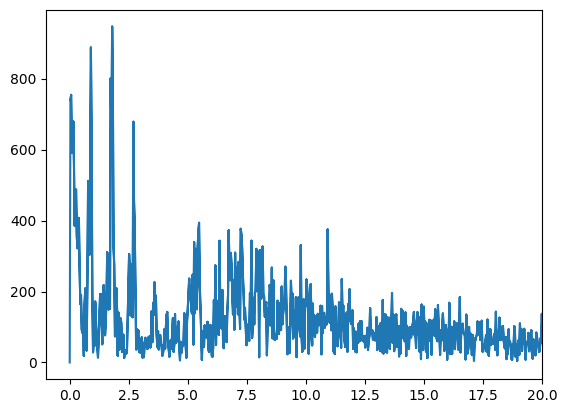

In [15]:
z = df['z'].values
z = z - np.mean(z)
yf_z = np.abs(fftpack.fft(z))
xf_z = fftpack.fftfreq(len(z), d=1/FS)
main_freq_z = xf_z[np.argmax(yf_z)]
print(f"Main frequency in z-axis: {main_freq_z:.2f} Hz")
plot_fft(z, fs=FS)

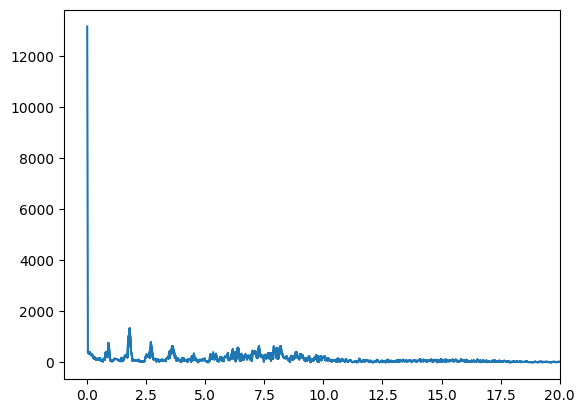

In [16]:
y = df['y'].values#TODO (Hint - plot for 'y' dataframe cloumn)
plot_fft(y)

### Questions
1. What is the meaning of the N, T, x, yf, xf variables?
2. What is the meaning of the ax.plot function?
3. What is the meaning of the ax.set_xlim function?
4. What is the main frequency in the z axis?
5. Plot the frequency domain of the y axis. What is the main frequency?

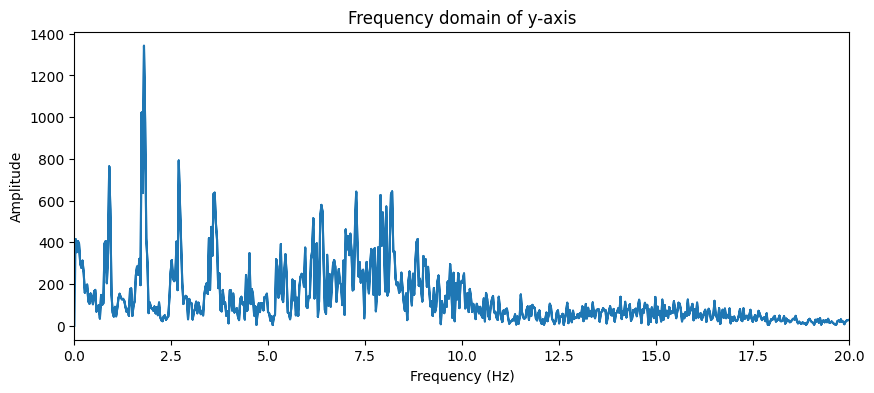

Main frequency in y-axis: 1.80 Hz


In [17]:
y = df['y'].values
y = y - np.mean(y)  # remove DC

# FFT using detected sampling rate
yf_y = np.abs(fftpack.fft(y))
xf_y = fftpack.fftfreq(len(y), d=1/FS)

plt.figure(figsize=(10,4))
plt.plot(np.abs(xf_y), np.abs(yf_y))
plt.xlim(0, 20)  # zoom in on low frequencies
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Frequency domain of y-axis")
plt.show()

main_freq_y = xf_y[np.argmax(yf_y)]
print(f"Main frequency in y-axis: {main_freq_y:.2f} Hz")






#### Your answers go here (double click here)

1.  
    N = no of data points in the signal
    T = sampling interval, i.e., time between consecutive samples
    x = time vector: generates N evenly spaced points from 0 to N*T seconds
    yf = magnitude of the FFT of the signal, representing the amplitude spectrum
    xf = frequency vector corresponding to yf

2. Plots data on the axes object ax

3. the limit of the x axis - max frequency to show

4. 0.1 Hz

5. 4.76 Hz




### Let's Talk About a Walk

"When a person walks, they bounce slightly with each step.  While people don't bounce very far, only one or two centimeters, it is one of the clearest, most constant, and most recognizable parts of a person's walking acceleration signal.

A person bounces up and down, in the vertical direction, with each step. If you are walking on Earth (or another big ball of mass floating in space) the bounce is conveniently in the same direction as gravity.

We are going to count steps by using the accelerometer to count bounces up and down. Because the phone can rotate in any direction, we will use gravity to know which direction down is. A pedometer can count steps by counting the number of bounces in the direction of gravity.

An accelerometer can measure acceleration including gravity. We can use the accelerometer to measure the acceleration due to gravity, and then use that to know which direction down is. We can then count bounces in the direction of gravity. Gravity is a constant acceleration.



### Questions
1. What is the frequency of a constant value signal?
2. If you had to obtain only the gravity component of the signal, how would you do it? what type of filter would you use?





#### Your answers go here (double click here)

1. 0 Hz

2. use a low-pass filter to remove higher-frequency movements like steps








## Filtering
Filters are used to remove unwanted components from a signal. They are used to remove noise and extract relevant information from the signal. There are different types of filters, including lowpass, highpass, and bandpass filters. A lowpass filter allows low-frequency components to pass through while attenuating high-frequency components. A highpass filter allows high-frequency components to pass through while attenuating low-frequency components. A bandpass filter allows a specific range of frequencies to pass through while attenuating frequencies outside that range.

We will use the **butter function** from the scipy library to create a lowpass filter. The butter function takes the filter order, cutoff frequency, sampling rate, and filter type as arguments. We will use the **filtfilt** function to apply the filter to the data. The filtfilt function takes the filter coefficients and the data as arguments. The filtfilt function will apply the filter twice, once forward and once backward. This will remove the phase shift introduced by the filter.

Let's create a function to apply a lowpass filter to the data.

In [18]:
#filter the data with a lowpass filter (gravity extraction)
from scipy import signal
from scipy.signal import butter, freqz, filtfilt

def lowpass_filter(data, low_cut_off=1, fs=FS):
    b, a = butter(4, low_cut_off, fs=fs, btype='lowpass', analog=False)
    y = filtfilt(b, a, data)
    return b, a, y


Let's now create a function to plot the frequency response of the filter.
We will  use the freqz function to obtain the frequency response of the filter. The freqz function takes the filter coefficients as arguments and it returns the frequency response and the frequencies associated with the frequency response. The frequency response is high for frequencies that are allowed to pass through and low for frequencies that are attenuated.

We will then use the plot function to plot the frequency response. The axvline function will plot a vertical line at the cutoff frequency.

In [19]:
def plot_frequency_response(b, a, low_cutoff=0, high_cutoff=0, fs=FS):
    # Plot the frequency response.
    w, h = freqz(b, a, fs=fs, worN=8000)
    plt.subplot(2, 1, 1)
    plt.plot(w, np.abs(h), 'b')
    if(low_cutoff > 0):
        plt.plot(low_cutoff, 0.5*np.sqrt(2), 'ko')
        plt.axvline(low_cutoff, color='k')
    if(high_cutoff > 0):
        plt.plot(high_cutoff, 0.5*np.sqrt(2), 'ko')
        plt.axvline(high_cutoff, color='k')

    plt.xlim(0, 20)
    plt.title("Lowpass Filter Frequency Response")
    plt.xlabel('Frequency [Hz]')
    plt.grid()

Now we are ready to apply the filter to the data. We will use the lowpass_filter function to apply the filter to the x, y, z columns. We will then plot the filtered data. We want to obtain the gravity component of the signal so we will allow frequencies below 1Hz to pass through.
We will also plot the frequency response of the filter to see how it affects the data.

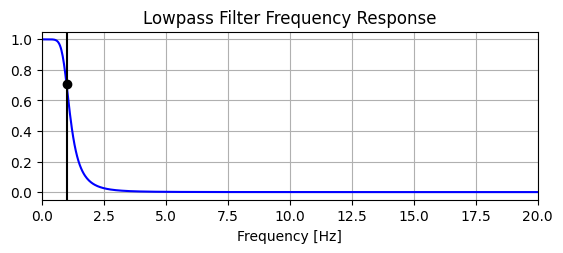

<Axes: >

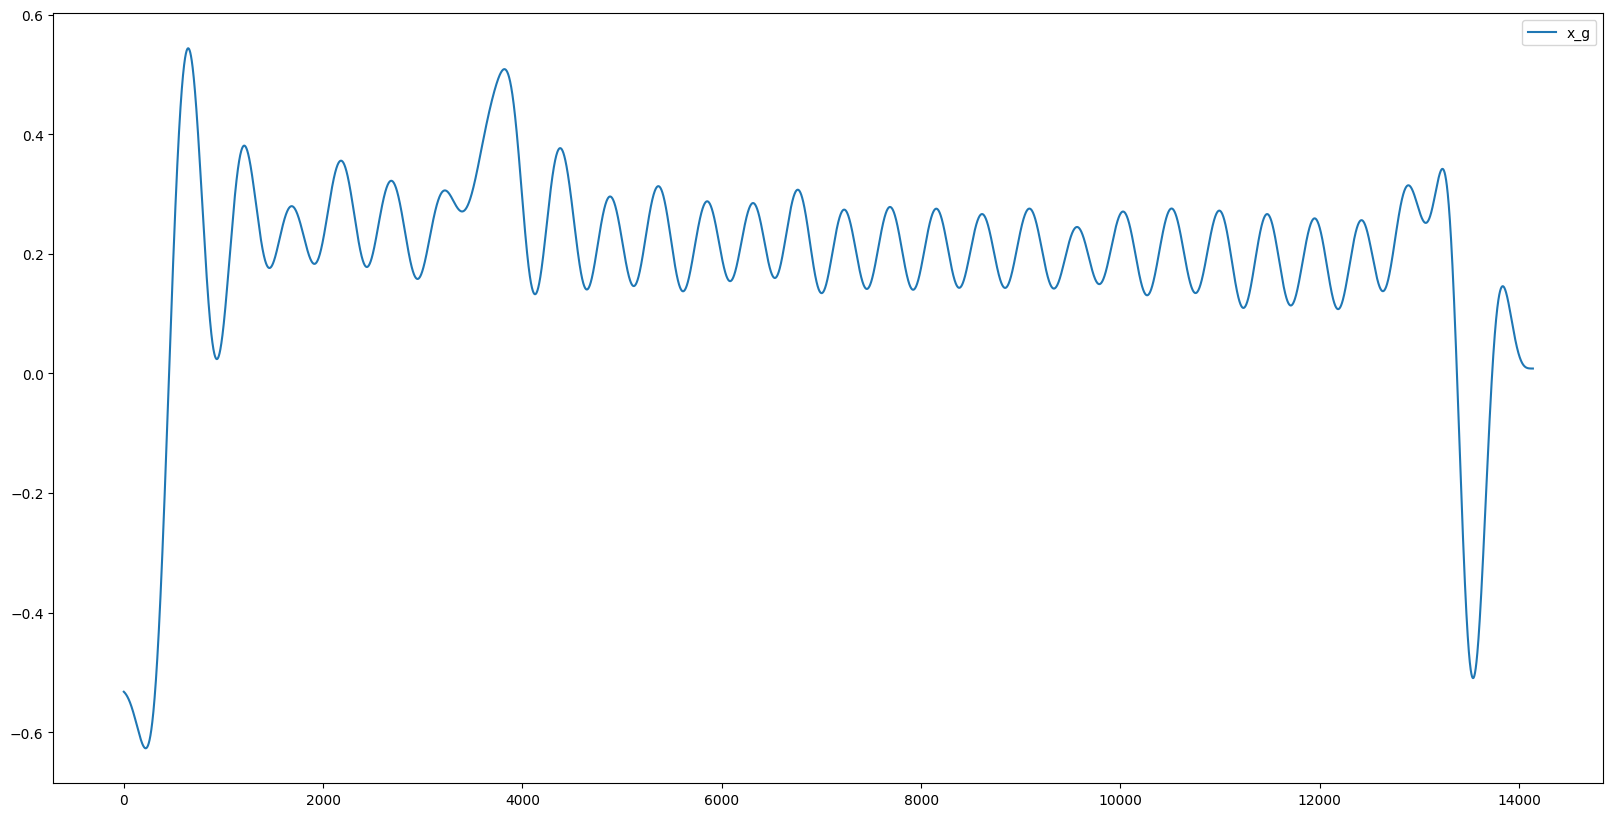

In [20]:
#obtain gravity component(just the x-axis)
b,a,df['x_g'] = lowpass_filter(df['x'].values, low_cut_off=1, fs=FS)
plot_frequency_response(b, a, low_cutoff=1, high_cutoff=0, fs=FS)
plt.show()

df[['x_g']].plot(figsize=(20,10))

## Interactive Task: Applying and Visualizing the Butterworth Lowpass Filter

In this section, you will:
1. Define and apply a **Butterworth filter (lowpass**) to isolate the gravity component from accelerometer data.
2. Explore the effect of filter parameters such as **cutoff frequency** and **filter order**.
3. Visualize the filtered signal alongside the original signal for all three axes (`x`, `y`, `z`).



### Instructions:
 **Complete the Code:** Fill in the `#TODO` placeholders to:
   - Specify the filter order in the `butterworth_filter` function.
   - Provide a cutoff frequency for the filter.  
   - Apply the filter to the `y` and `z` axis.

NOTE : If you are confused, see the 3 blocks of code above and find the TODO values there

**Experiment:**
  - Try different filter orders ( `2`, `4`, `8`) and observe how the roll-off steepness changes.
  - Adjust the cutoff frequency (`1 Hz`, `2 Hz`, `5 Hz`) and observe the changes in the frequency response.

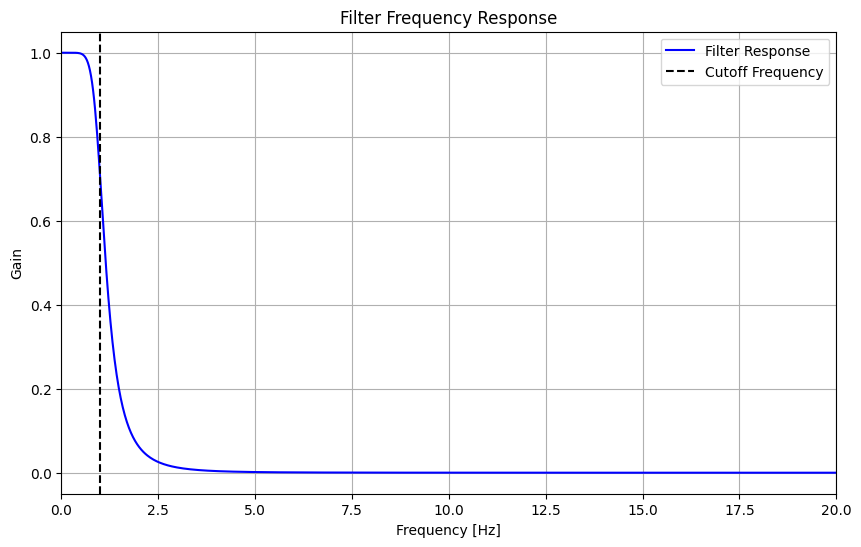

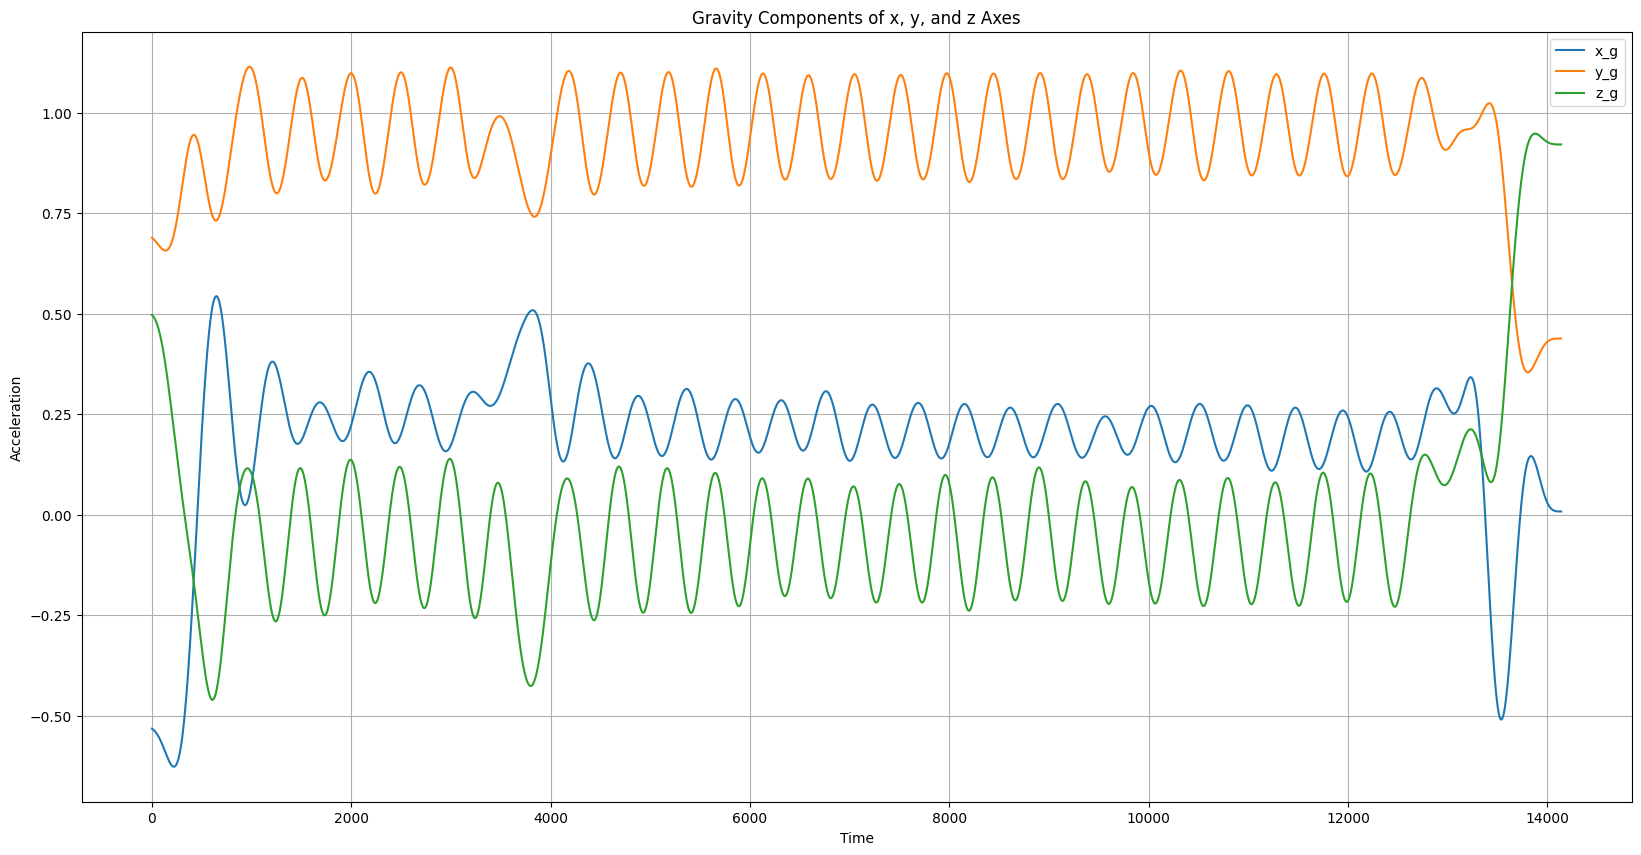

In [21]:
from scipy.signal import butter, freqz, filtfilt
import matplotlib.pyplot as plt

# Define the Butterworth filter function
def butterworth_filter(data, cutoff, fs=FS):
    """
    Apply a Butterworth lowpass filter to the data.

    Parameters:
        data: The input signal.
        cutoff (float): The cutoff frequency for the lowpass filter.
        fs (float): The sampling rate of the data.

    Returns:
        b, a: Filter coefficients.
        y: Filtered signal.
    """

    filter_order = 4
    #(hint - check lowpass_filter function few blocks above)

    b, a = butter(filter_order, cutoff, fs=fs, btype='lowpass', analog=False)
    y = filtfilt(b, a, data)

    return b, a, y

# Define the frequency response plotting function
def plot_frequency_response(b, a, cutoff, fs=FS):
    """
    Plot the frequency response of the filter.

    Parameters:
        b, a: Filter coefficients.
        cutoff (float): The cutoff frequency.
        fs (float): The sampling rate.
    """
    w, h = freqz(b, a, fs=fs, worN=8000)
    plt.figure(figsize=(10, 6))
    plt.plot(w, abs(h), 'b', label="Filter Response")
    plt.axvline(cutoff, color='k', linestyle='--', label='Cutoff Frequency')
    plt.xlim(0, 20)
    plt.title("Filter Frequency Response")
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Gain')
    plt.grid()
    plt.legend()
    plt.show()


# Specify the cutoff frequency
cutoff = 1
#(hint: Specify the cutoff frequency (e.g., 1))

# Obtain the gravity component for the x-axis
b, a, df['x_g'] = butterworth_filter(df['x'].values, cutoff, fs=FS)

# Plot the frequency response of the lowpass filter
plot_frequency_response(b, a, cutoff, fs=FS)
plt.show()

# Apply the lowpass filter to obtain the gravity component for the y and z axes
b, a, df['y_g'] = lowpass_filter(df['y'].values, low_cut_off=1, fs=FS)
b, a, df['z_g'] = lowpass_filter(df['z'].values, low_cut_off=1, fs=FS)
#(hint - Obtain the y_g and z_g values the same way we obtained the x_g value above)

# Plot the gravity components of all axes
df[['x_g', 'y_g', 'z_g']].plot(figsize=(20, 10))
plt.title('Gravity Components of x, y, and z Axes')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.legend(['x_g', 'y_g', 'z_g'])
plt.grid()
plt.show()




**Answer the Questions Below:**
   1. What is your observation of the gravity component plot when filter order is :  `2`, `4`, `8`? How do they differ?
   2. How does changing the cutoff frequency affect the gravity component?
   3. Compare the filtered signals for `x`, `y`, and `z`. What similarities or differences do you observe?

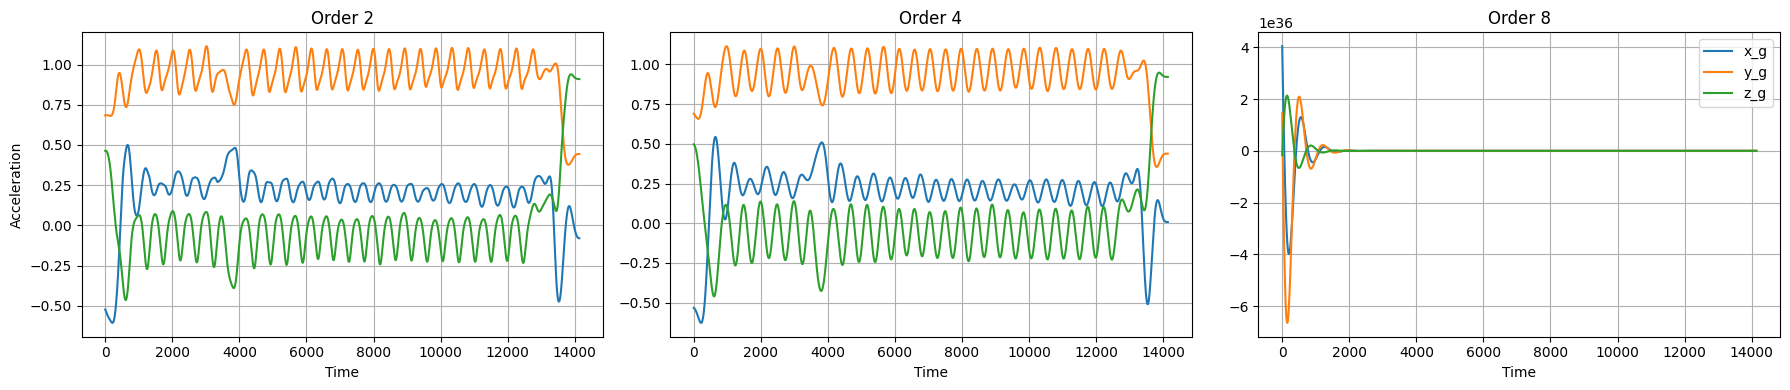

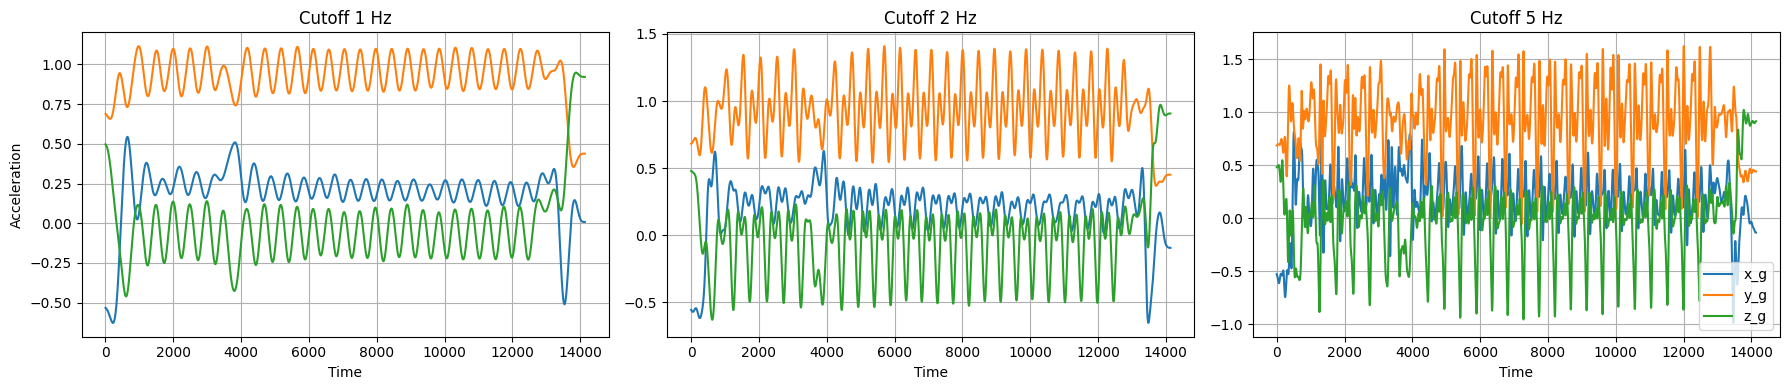

In [22]:
# make sure butterworth_filter accepts filter_order
def butterworth_filter(data, cutoff, fs=FS, filter_order=4):
    b, a = butter(filter_order, cutoff, fs=fs, btype='lowpass', analog=False)
    y = filtfilt(b, a, data)
    return b, a, y

import matplotlib.pyplot as plt

# Q1: varying filter order
orders = [2, 4, 8]
plt.figure(figsize=(18,4))
for i, order in enumerate(orders):
    x_g = butterworth_filter(df['x'].values, cutoff=1, fs=FS, filter_order=order)[2]
    y_g = butterworth_filter(df['y'].values, cutoff=1, fs=FS, filter_order=order)[2]
    z_g = butterworth_filter(df['z'].values, cutoff=1, fs=FS, filter_order=order)[2]

    plt.subplot(1, 3, i+1)
    plt.plot(df.index, x_g, label='x_g')
    plt.plot(df.index, y_g, label='y_g')
    plt.plot(df.index, z_g, label='z_g')
    plt.title(f'Order {order}')
    plt.xlabel('Time')
    plt.grid(True)
    if i == 0: plt.ylabel('Acceleration')
    if i == 2: plt.legend()
plt.tight_layout()
plt.show()

# Q2: varying cutoff frequency
cutoffs = [1, 2, 5]  # Hz
plt.figure(figsize=(18,4))
for i, cutoff in enumerate(cutoffs):
    x_g = butterworth_filter(df['x'].values, cutoff=cutoff, fs=FS, filter_order=4)[2]
    y_g = butterworth_filter(df['y'].values, cutoff=cutoff, fs=FS, filter_order=4)[2]
    z_g = butterworth_filter(df['z'].values, cutoff=cutoff, fs=FS, filter_order=4)[2]

    plt.subplot(1, 3, i+1)
    plt.plot(df.index, x_g, label='x_g')
    plt.plot(df.index, y_g, label='y_g')
    plt.plot(df.index, z_g, label='z_g')
    plt.title(f'Cutoff {cutoff} Hz')
    plt.xlabel('Time')
    plt.grid(True)
    if i == 0: plt.ylabel('Acceleration')
    if i == 2: plt.legend()
plt.tight_layout()
plt.show()






#### Your answers go here (double click here)

1. Higher filter order = steeper cutoff, cleaner gravity

2. Lower cutoff = better isolation of gravity, higher cutoff = retains more movement artifacts.

3. z-axis has the largest magnitude (vertical direction), x-axis shows moderate tilt variations, and y-axis lies between them,



---





---



### Chebyshev Filter (TYPE-I)

A Chebyshev Type I filter is a lowpass or highpass filter that provides a steeper roll-off than a Butterworth filter by allowing controlled ripple in the passband.

Key points:

**Roll-off** determines how steeply the filter transitions between passband and stopband.

**Ripple** controls the smoothness of the passband or stopband response, with higher ripple leading to less flat responses.



**Differences Between Butterworth and Chebyshev Filters**

*   **Passband Behavior**:

Butterworth: Provides a maximally flat frequency response in the passband (no ripple).

Chebyshev: Allows ripple in the passband, resulting in a sharper roll-off at the cutoff frequency.
*   **Steepness of Roll-Off**:

Chebyshev: Offers a steeper roll-off compared to Butterworth for the same filter order.

Butterworth: Has a gentler roll-off but a smoother passband.
*   **Ripple Parameter**:

Chebyshev filters have a ripple parameter that allows control over the passband ripple (in decibels).

Butterworth filters don't have this parameter.
*   **Usage**:

Butterworth: Preferred when a smooth passband is critical (e.g., audio processing).

Chebyshev: Preferred when a sharp cutoff is needed, even at the expense of passband ripple.




## Interactive Task: Applying the Chebyshev Type I Lowpass Filter

In this section, you will:
1. Explore the effect of **Chebyshev filter parameters** (filter order, cutoff frequency, and ripple) on accelerometer data.
2. Compare the Chebyshev filter results to the Butterworth filter.



### Instructions:
1. **Tasks**:

   - Modify the **filter order** (`filter_order`) value to 4 or a value of your choice. (Make sure the order of chebyshev filter is same as butterworth when comparing)
   - Change the **cutoff frequency** (`cutoff`) to `1 Hz`, `5 Hz`, or `10 Hz`. (Here also, Make sure this value is same as butterworth when comparing for an even comparision)
   - Experiment with different **ripple values** (e.g., `1 dB`, `5 dB`, `10 dB`).

2. **Analyze the Filter Behavior**:
   - Observe how the **frequency response** changes with different filter orders and ripple values.
   - Note the differences in the **time-domain filtered signal** (x, y, z axes) compared to the Butterworth filter.




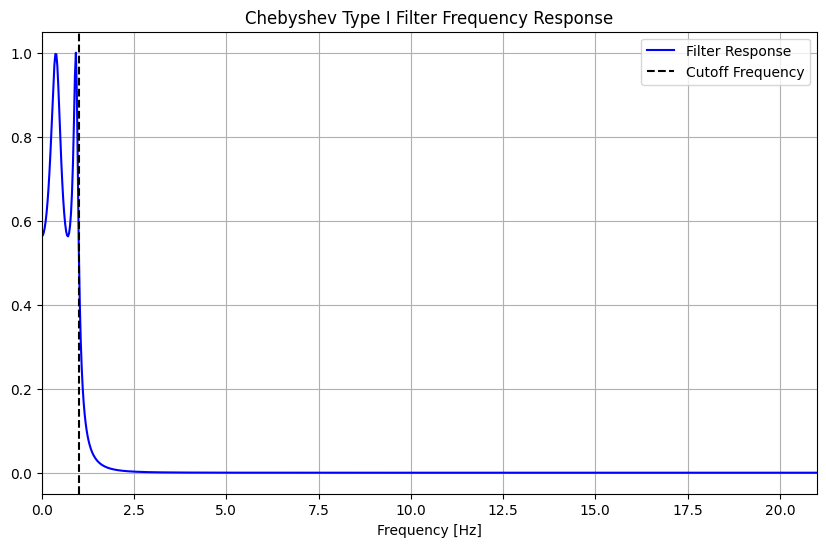

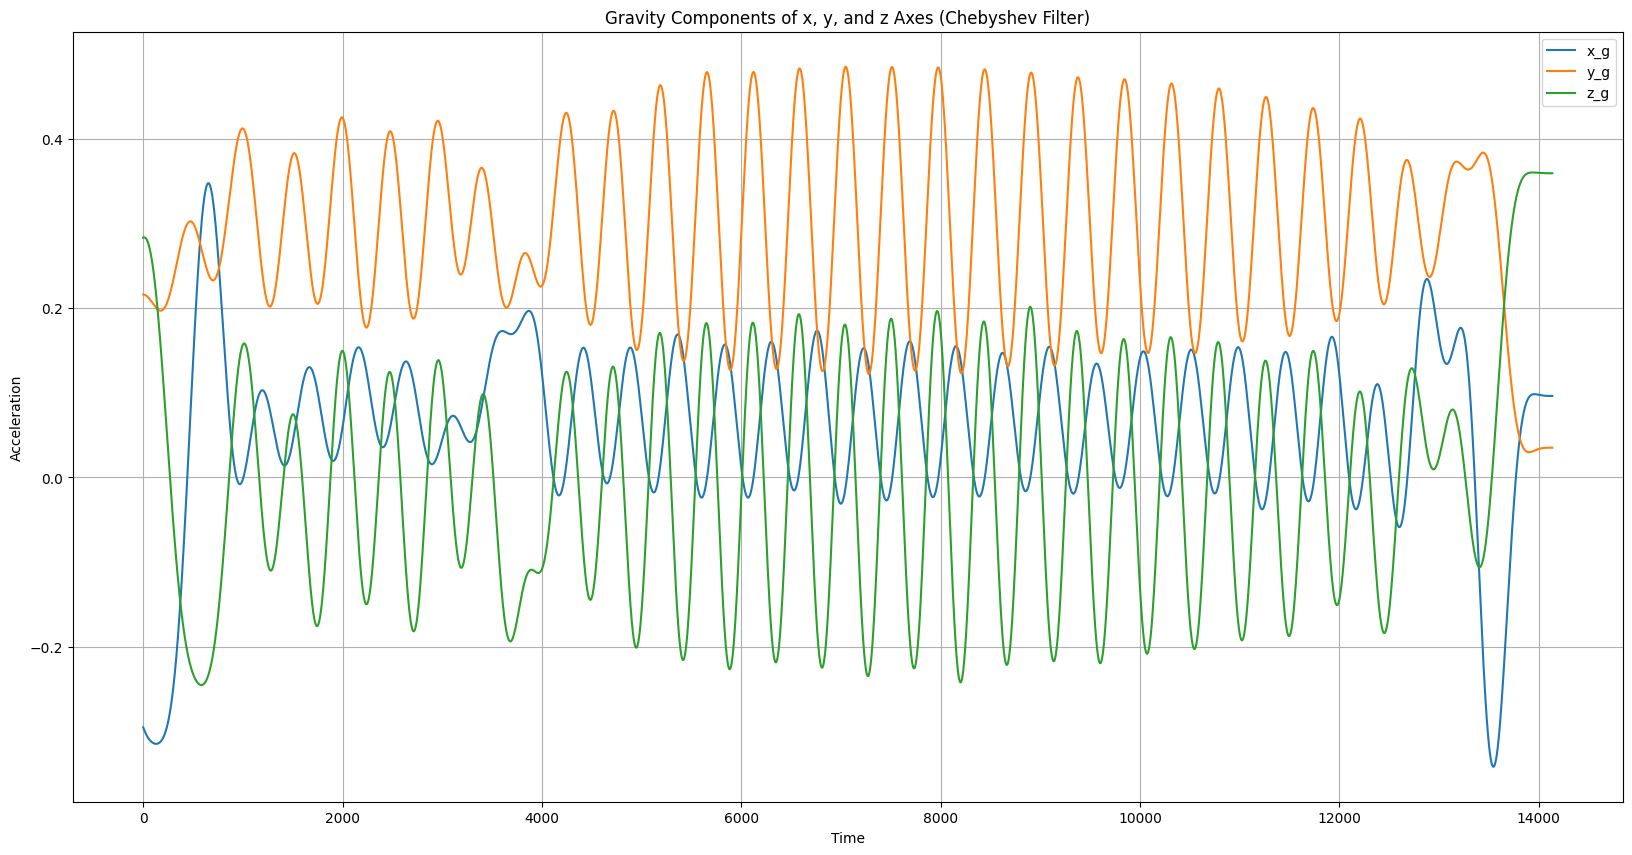


EXPERIMENT: Comparing different ripple values


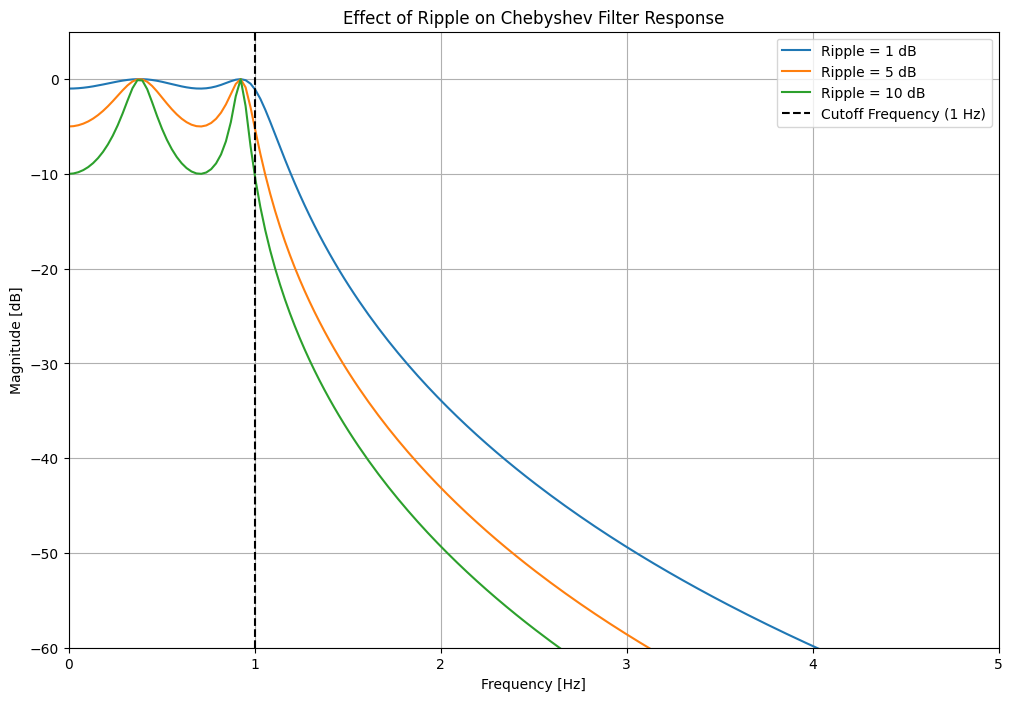


EXPERIMENT: Comparing different filter orders


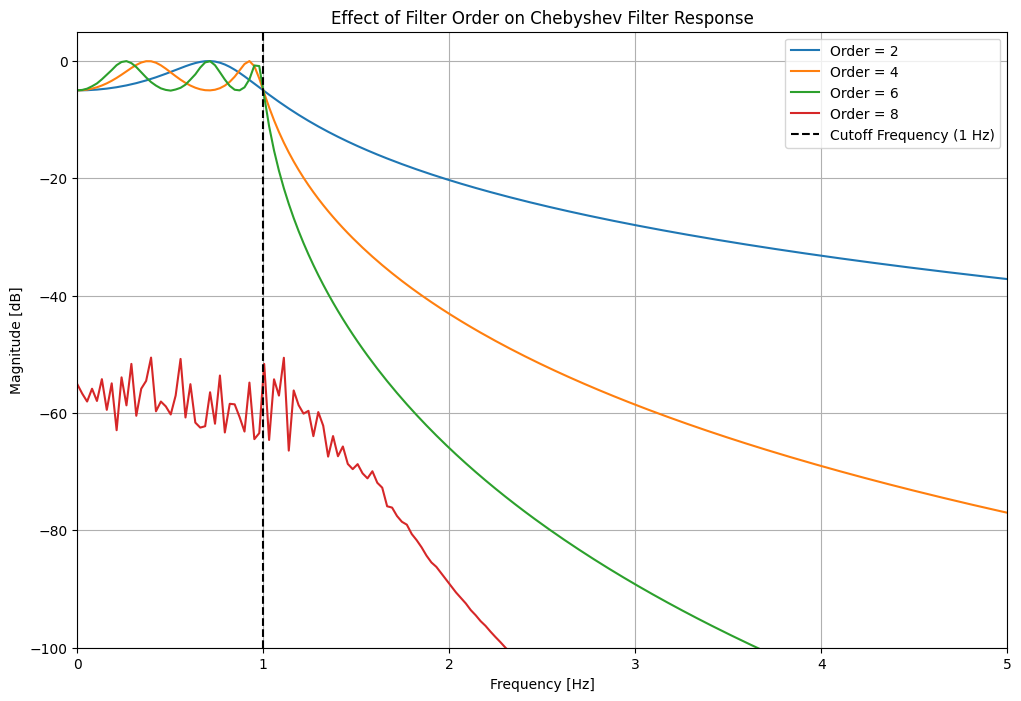


ANSWERS TO QUESTIONS


In [23]:
from scipy.signal import cheby1, freqz, filtfilt
import matplotlib.pyplot as plt

# Define the Chebyshev Type I filter function
def chebyshev_filter(data, cutoff, fs=FS, ripple=5):
    """
    Apply a Chebyshev Type I lowpass filter to the data.

    Parameters:
        data: The input signal.
        cutoff (float): The cutoff frequency for the lowpass filter.
        fs (float): The sampling rate of the data.
        ripple (float): Maximum ripple allowed in the passband (dB).

    Returns:
        b, a: Filter coefficients.
        y: Filtered signal.
    """
    filter_order = 4
    #Hint - Put order of your choice (When comparing, make sure filter order is same as butterworth filter above. Ideally Keep both 4)

    b, a = cheby1(filter_order, ripple, cutoff / (fs / 2), btype='lowpass', analog=False)  # Normalize cutoff
    y = filtfilt(b, a, data)  # Apply the filter
    return b, a, y

# Define the frequency response plotting function
def plot_frequency_response(b, a, cutoff, fs=FS):
    """
    Plot the frequency response of the filter.

    Parameters:
        b, a: Filter coefficients.
        cutoff (float): The cutoff frequency.
        fs (float): The sampling rate.
    """
    w, h = freqz(b, a, fs=fs, worN=8000)
    plt.figure(figsize=(10, 6))
    plt.plot(w, abs(h), 'b', label="Filter Response")
    plt.axvline(cutoff, color='k', linestyle='--', label='Cutoff Frequency')
    plt.xlim(0, cutoff+20)
    plt.title("Chebyshev Type I Filter Frequency Response")
    plt.xlabel('Frequency [Hz]')
    plt.grid()
    plt.legend()
    plt.show()


# TODO - Specify the cutoff frequency (e.g., 1, 2, 5, 50 Hz)
cutoff = 1
#Hint -  Put cutoff freq of your choice (When comparing, make sure the value is same as butterworth filter you put above. Ideally keep both 1)


# Plot the frequency response
# Obtain the gravity component for the x-axis
b, a, df['x_g'] = chebyshev_filter(df['x'].values, cutoff, fs=FS)

# Plot the frequency response of the lowpass filter
plot_frequency_response(b, a, cutoff, fs=FS)
plt.show()

# Apply the lowpass filter to obtain the gravity component for the y and z axes
b, a, df['y_g'] = chebyshev_filter(df['y'].values, cutoff, fs=FS, ripple=5)
b, a, df['z_g'] = chebyshev_filter(df['z'].values, cutoff, fs=FS, ripple=5)

# Plot the gravity components of all axes
df[['x_g', 'y_g', 'z_g']].plot(figsize=(20, 10))
plt.title('Gravity Components of x, y, and z Axes (Chebyshev Filter)')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.legend(['x_g', 'y_g', 'z_g'])
plt.grid()
plt.show()




print("\n" + "="*60)
print("EXPERIMENT: Comparing different ripple values")
print("="*60)

# Compare different ripple values
ripple_values = [1, 5, 10]
plt.figure(figsize=(12, 8))

for ripple in ripple_values:
    b, a, _ = chebyshev_filter(df['x'].values, cutoff=1, fs=FS, ripple=ripple)
    w, h = freqz(b, a, fs=FS, worN=8000)
    plt.plot(w, 20 * np.log10(abs(h)), label=f'Ripple = {ripple} dB')

plt.axvline(1, color='k', linestyle='--', label='Cutoff Frequency (1 Hz)')
plt.xlim(0, 5)
plt.ylim(-60, 5)
plt.title('Effect of Ripple on Chebyshev Filter Response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.legend()
plt.show()

print("\n" + "="*60)
print("EXPERIMENT: Comparing different filter orders")
print("="*60)

# Compare different filter orders
orders = [2, 4, 6, 8]
plt.figure(figsize=(12, 8))

for order in orders:
    b, a = cheby1(order, 5, 1 / (FS / 2), btype='lowpass', analog=False)
    w, h = freqz(b, a, fs=FS, worN=8000)
    plt.plot(w, 20 * np.log10(abs(h)), label=f'Order = {order}')

plt.axvline(1, color='k', linestyle='--', label='Cutoff Frequency (1 Hz)')
plt.xlim(0, 5)
plt.ylim(-100, 5)
plt.title('Effect of Filter Order on Chebyshev Filter Response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.legend()
plt.show()

print("\n" + "="*60)
print("ANSWERS TO QUESTIONS")
print("="*60)



---

### Questions:
1. How does increasing the **ripple value** affect the filter response in the Filter frequency response plot ?
2. Compare the steepness of the roll-off between Chebyshev and Butterworth filters. Which filter has a sharper roll-off? (Which filter will have the the gain drop to 0 quicker for higher frequencies)
3. What is the impact of a higher **filter order** on the frequency response? Does it Roll-off quicker with higher order?





#### Your answers go here (double click here)

1. Increasing the ripple value causes MORE OSCILLATION
Trade-off: More ripple = Sharper roll-off but less flat passband
          Less ripple = Gentler roll-off but flatter passband

2. The CHEBYSHEV filter. thats the advantage of the Chebyshev filter - it achieves better frequency selectivity at the cost of passband ripple.

3. higher filter order results in a QUICKER roll-off






---


---

In [24]:
#Run this cell to adjust x_g, y_g, and z_g values back to our original setting
from scipy.signal import butter, freqz, filtfilt

def lowpass_filter(data, low_cut_off=1, fs=FS):
    b, a = butter(4, low_cut_off, fs=fs, btype='lowpass', analog=False)
    y = filtfilt(b, a, data)
    return b, a, y

b,a,df['x_g'] = lowpass_filter(df['x'].values, low_cut_off=1, fs=FS)
b,a,df['y_g'] = lowpass_filter(df['y'].values, low_cut_off=1, fs=FS)
b,a,df['z_g'] = lowpass_filter(df['z'].values, low_cut_off=1, fs=FS)

Each time series measures the total acceleration in that direction. Total acceleration is the sum of user acceleration and gravitational acceleration.

User acceleration is the acceleration of the device due to the movement of the user, and is constant at 0 when the phone is perfectly still. However, when the user is moving with the device, user acceleration is rarely constant, since it's difficult for a person to move with a constant acceleration. User acceleration is the acceleration we want to measure to count steps.

TO obtain user acceleration we will subtract the gravity component from the total acceleration. We will create a new column for each axis to store the user acceleration.

<Axes: xlabel='timestamp'>

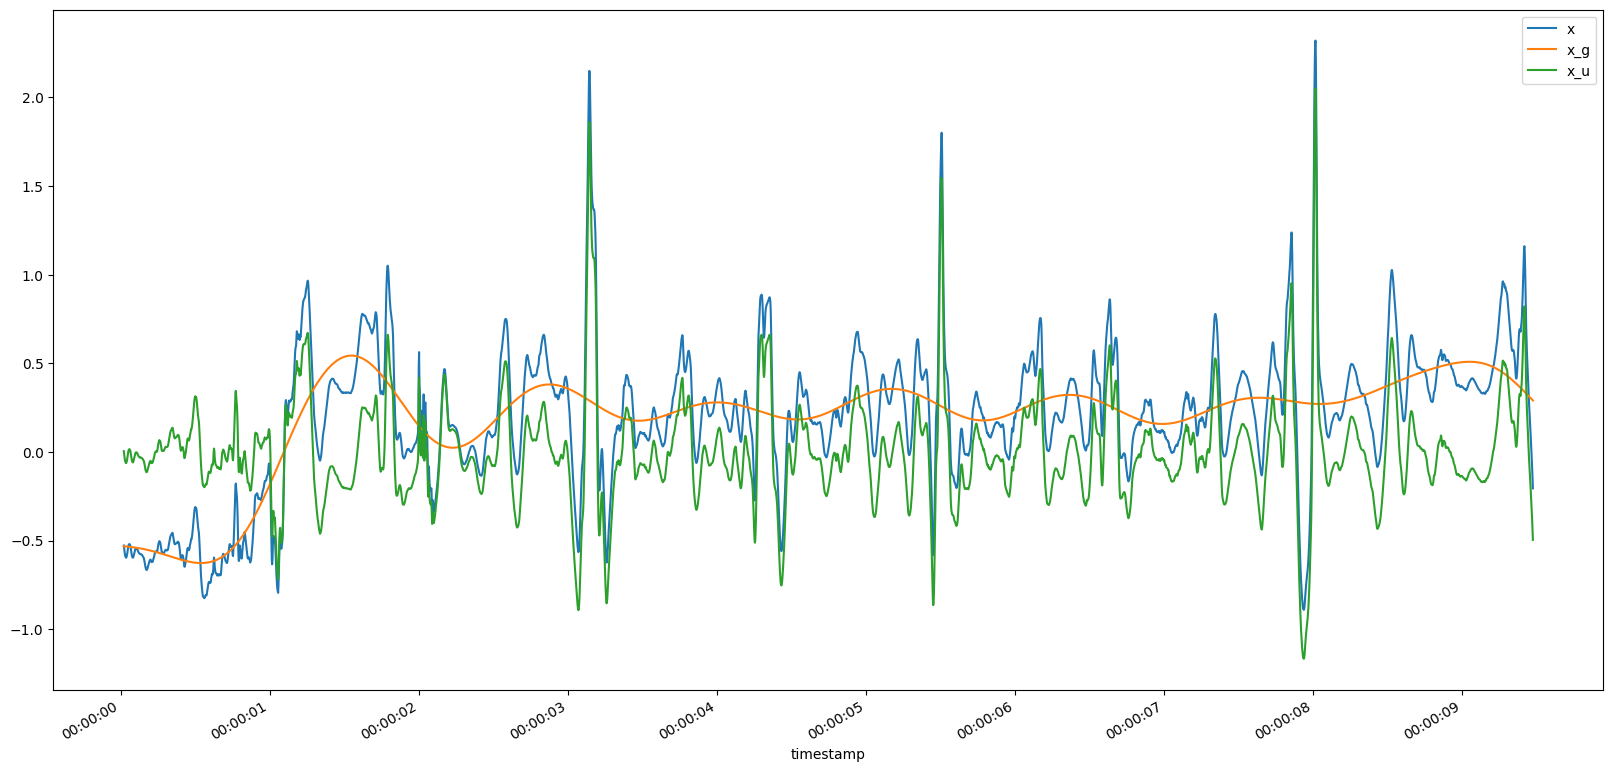

In [25]:
df['x_u'] = df['x'] - df['x_g']
df['y_u'] = df['y'] - df['y_g']
df['z_u'] = df['z'] - df['z_g']

#limit the plot to 10 seconds
df.head(4000).plot(x='timestamp', y=['x', 'x_g', 'x_u'], figsize=(20,10))

"xu(t) , yu(t), and zu(t) include all movements of the user, not just movements in the direction of gravity. Our goal here is to end up with a 1-dimensional time series representing user acceleration in the direction of gravity. This will include portions of user acceleration in each of the directions.

Let's get to it. First, some linear algebra 101. Don't take that mathematician hat off just yet!

###  The Dot Product

When working with coordinates, you won't get very far before being introduced to the dot product, one of the fundamental tools used in comparing the magnitude and direction of x, y, and z coordinates.

The dot product takes us from 3-dimensional space to 1-dimensional space. When we take the dot product of the two time series, user acceleration and gravitational acceleration, both of which are in 3-dimensional space, we'll be left with a single time series in 1-dimensional space representing the portion of user acceleration in the direction of gravity. We'll arbitrarily call this new time series a, because, well, every important time series deserves a name." [1]

<Axes: xlabel='timestamp'>

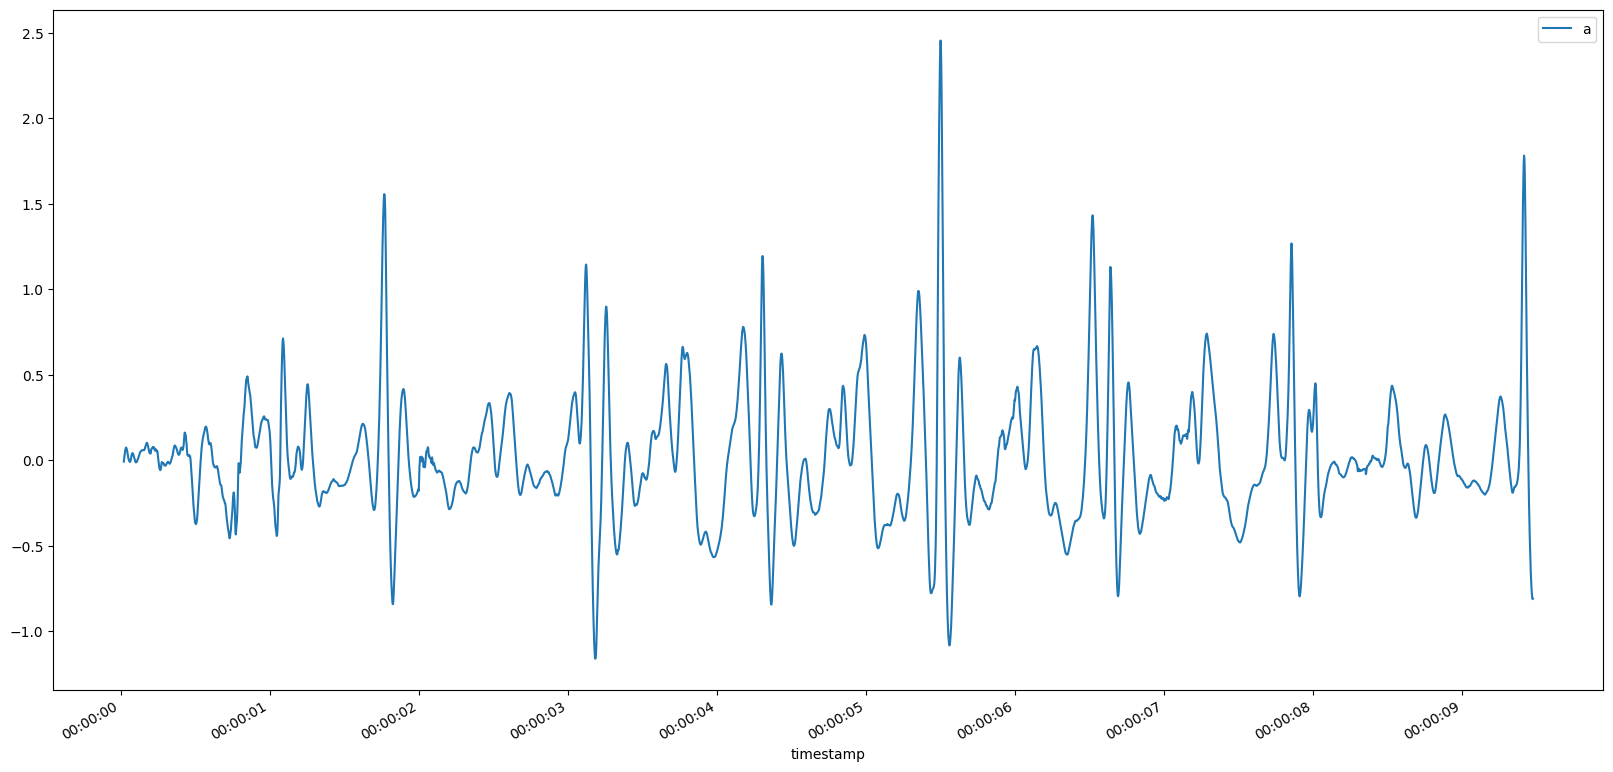

In [26]:
#dot product of g and u


df['a'] = df['x_g'] * df['x_u'] + df['y_g'] * df['y_u'] + df['z_g'] * df['z_u']
#Hint- take dot product of 'g' and 'u' component of the 3 axis and add them

df.head(4000).plot(x='timestamp', y=['a'], figsize=(20,10))

### Questions
1. What is the meaning of the x_g, y_g, z_g, x_u, y_u, z_u, a columns?
2. What is the meaning of the dot product?
3. What is the meaning of the a column?





#### Your answers go here (double click here)

1. Gravity components (x_g, y_g, z_g), user acceleration components (x_u, y_u, z_u), and user acceleration in gravity direction (a)

2. Projection of  the 3D user acceleration vector onto the 3D gravity vector to get a scalar magnitude.

3. User acceleration in the direction of gravity, representing vertical bouncing motion used for step detection





## Interactive Task: Analyzing the Frequency Domain of User Acceleration Signal (FFT)

In this section, you will explore the frequency domain representation of the user acceleration signal using **Fast Fourier Transform (FFT).** FFT helps us analyze the frequency components present in the signal, which is crucial for identifying patterns, such as the frequency of steps in our data.



**Instructions**:
* Set Parameters: Modify the values of the sampling rate (fs) and duration  to explore different segments of the signal.
* fs is the **sampling rate** in Hz (**Set it to 400 Hz**).

* **duration (you can set it to 2 sec, 5 sec or 10 sec)** specifies how many seconds of data to analyze.
* Observe the Plot: Run the code to view the frequency domain representation of the signal for the specified duration. See which frequencies dominate in general

**Interpret the Plot:**
* The x-axis represents frequency (Hz).
* The y-axis represents the magnitude of the frequency components.
* Peaks in the plot correspond to dominant frequencies in the signal.



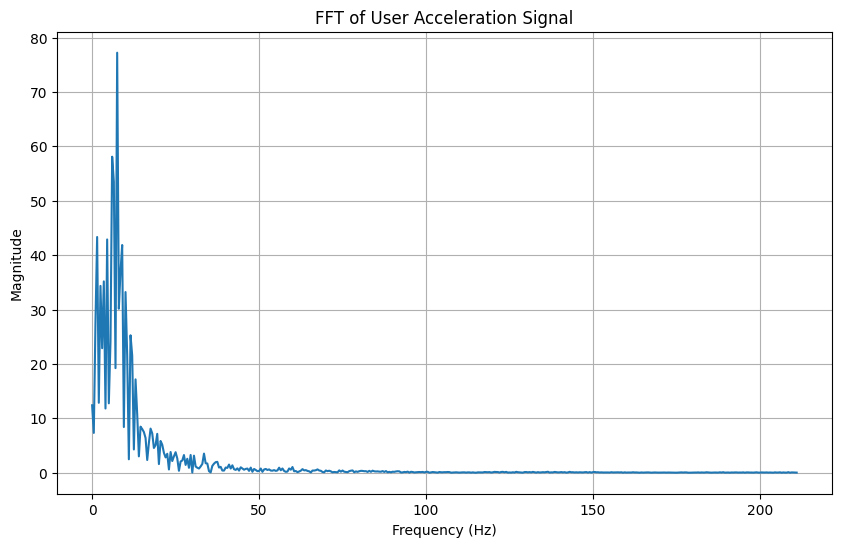

In [27]:
# Interactive FFT Task
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

def apply_fft(data, fs, duration):
    """
    Perform FFT on a subset of the data and plot the frequency domain representation.

    Parameters:
        data: Input time-domain signal.
        fs: Sampling rate in Hz.
        duration: Duration of the signal to analyze in seconds.
    """
    # Select a subset of the data based on the duration
    N = int(fs * duration)  # Number of samples for the specified duration
    signal = data[:N]

    # Perform FFT
    yf = fft(signal)
    xf = fftfreq(N, 1 / fs)  # Frequency bins

    # Plot the FFT
    plt.figure(figsize=(10, 6))
    plt.plot(xf[:N // 2], abs(yf[:N // 2]))  # Plot positive frequencies only
    plt.title("FFT of User Acceleration Signal")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid()
    plt.show()

# Sampling rate (use detected FS by default)
fs = FS

# duration of the signal
duration = 2

# Call the interactive FFT function
apply_fft(df['a'].values, fs=fs, duration=duration)



**Questions:**
1. What is the dominant frequency visible in the FFT plot?
2. How does increasing the duration parameter affect the FFT plot? Do you observe more or fewer frequency components?
3. If the sampling rate (fs) is reduced to 200 Hz, what changes do you notice in the FFT plot? Can you still identify the dominant frequency?
4. How could FFT analysis help in filtering the data or improving the step detection algorithm?





#### Your answers go here (double click here)


1. Dominant frequency is typically 1-3 Hz (normal walking cadence)


2. Increasing duration gives better frequency resolution but same frequency components


3. At 200 Hz, max detectable frequency drops to 100 Hz but dominant frequency still visible


4. FFT identifies step frequency range (1-5 Hz) to design optimal bandpass filter cutoffs






The apply_fft function we created earlier allows us to interactively analyze specific segments of the signal by adjusting parameters like duration, making it ideal for exploring localized frequency patterns and understanding the impact of different time windows on the FFT.

 In contrast, the plot_fft function provides a static, full-signal frequency domain analysis, quickly generating an overall spectrum but without flexibility for focused exploration.

 We will now use plot_fft for quick analysis of the entire dataset and a broad understanding of the signal's frequency composition.

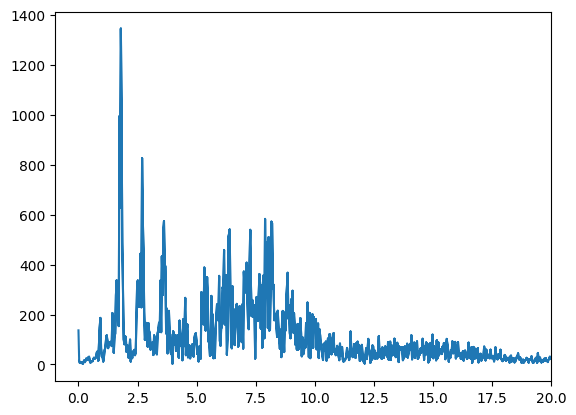

In [28]:
#obtain a frequency domain representation of the entire data using fftpack
plot_fft(df['a'].values)

## Step Counting
Now that we have obtained the user acceleration in the direction of gravity, we can start counting steps. We will use the find_peaks function from the scipy library to identify peaks in the data.
However, there are still some  issues with our a signal in its current state.
1. **jumpy peaks**: The peaks are jumpy. This is because the accelerometer is sensitive to noise, causing high frequency components to be present in the signal. We will remove frequencies above 5Hz as people have determined this is the highest frequency of a step.
2. **slow peaks** : with the high sampling rate, we can detect some peaks that are too slow to be a step. People have determined that the slowest steps are at 1Hz. We will remove frequencies below 1Hz.
3. **Short Peaks**: As a person is using an app or making a call, the accelerometer registers small movements in the direction of gravity, presenting themselves as short peaks in our time series. We can eliminate these short peaks by setting a minimum threshold, and counting a step every time a(t) crosses that threshold in the positive direction.


## Interactive Task: Applying and Visualizing a Bandpass Filter
In this section, you will:

Define and apply a bandpass filter to retain frequencies between low_cutoff and high_cutoff.
Explore the effect of varying the cutoff frequencies on the filtered signal.
Visualize the filtered signal alongside the original signal to observe the effects of the bandpass filter.

**Instructions:**
Complete the Code:

Fill in the #TODO placeholders in the bandpass_filter function.
Use the butter function to create a bandpass filter with both low_cut_off and high_cut_off.

Use the filtfilt function to apply the filter to the data.

**Experiment [OPTIONAL]:**

Change the values of low_cutoff and high_cutoff to observe how the filtered signal changes.
For example:
Try low_cutoff = 1 Hz and high_cutoff = 5 Hz.
Adjust high_cutoff to 10 Hz or 20 Hz to see the effect of allowing more frequencies through.
Compare the frequency response plots for different cutoff frequency combinations.

**Visualization:**

Use the provided frequency response plot function to see the filter's characteristics.
Observe how the filtered signal behaves compared to the original signal in the time-domain plot.

In [29]:
#remove frequencies below 1Hz and above 5Hz
def bandpass_filter(data, low_cut_off, high_cut_off, fs=FS):
    """
    Apply a bandpass filter to the data to retain frequencies between low_cut_off and high_cut_off.

    Parameters:
        data: Input signal.
        low_cut_off (float): Lower cutoff frequency (Hz).
        high_cut_off (float): Upper cutoff frequency (Hz).
        fs (float): Sampling rate (Hz).

    Returns:
        b, a: Filter coefficients.
        y: Filtered signal.
    """
    order = 4

    # Create the filter coefficients
    b, a = butter(order, [low_cut_off / (fs / 2), high_cut_off / (fs / 2)], btype='bandpass', analog=False)
    y = filtfilt(b, a, data)
    return b, a, y



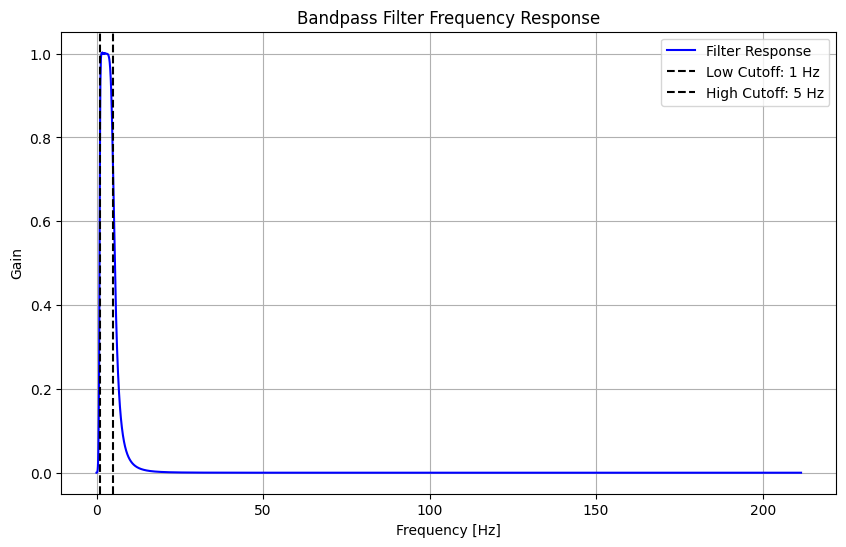

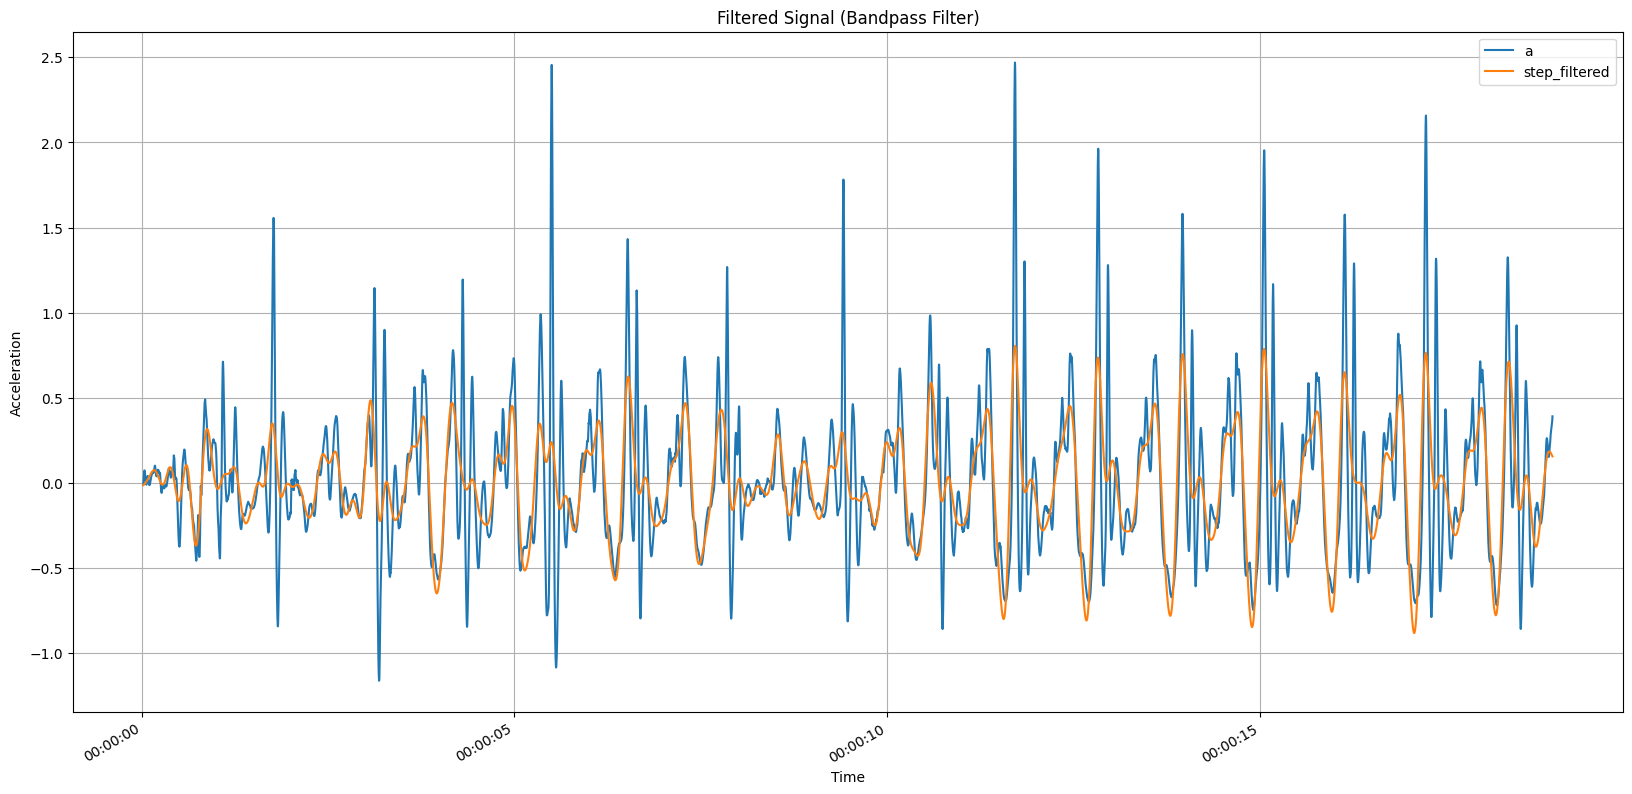

In [30]:
#Set low_cutoff and high_cutoff frequencies
low_cutoff =  1
high_cutoff = 5  # You can change these values if you want to experiment with this filter

b,a, df['step_filtered'] = bandpass_filter(df['a'].values, low_cutoff, high_cutoff, fs=FS)
# Plot the frequency response of the bandpass filter
def plot_frequency_response(b, a, low_cutoff, high_cutoff, fs=FS):
    """
    Plot the frequency response of the bandpass filter.

    Parameters:
        b, a: Filter coefficients.
        low_cutoff: Lower cutoff frequency.
        high_cutoff: Upper cutoff frequency.
        fs: Sampling rate.
    """
    w, h = freqz(b, a, fs=fs, worN=8000)
    plt.figure(figsize=(10, 6))
    plt.plot(w, abs(h), 'b', label="Filter Response")
    plt.axvline(low_cutoff, color='k', linestyle='--', label=f"Low Cutoff: {low_cutoff} Hz")
    plt.axvline(high_cutoff, color='k', linestyle='--', label=f"High Cutoff: {high_cutoff} Hz")
    plt.title("Bandpass Filter Frequency Response")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Gain")
    plt.grid()
    plt.legend()
    plt.show()

# Plot the frequency response
plot_frequency_response(b, a, low_cutoff, high_cutoff, fs=FS)
plt.show()

# Visualize the filtered signal
df.head(8000).plot(x='timestamp', y=['a', 'step_filtered'], figsize=(20, 10))
plt.title("Filtered Signal (Bandpass Filter)")
plt.xlabel("Time")
plt.ylabel("Acceleration")
plt.grid()
plt.show()

Now we are ready to find the peaks.
The find_peaks function takes the data as an argument and returns the indices of the peaks. THe second argument is the height argument. The height argument specifies the minimum height of the peaks. We will set the height to 0.1. This means that we will only detect peaks that are at least 0.1.
Finally, it will also take a distance argument. The distance argument specifies the minimum distance between two peaks. We will set the distance to 100. This means that we will only detect peaks that are at least 100 samples apart (0.25 seconds).
We will then create a new column to store the peaks. We will set the value of the peaks to 100 so we can easily visualize where they are.

Peak tuning: height=0.2, min_separation=0.25s (105 samples at FS≈423.10Hz)


<Axes: xlabel='timestamp'>

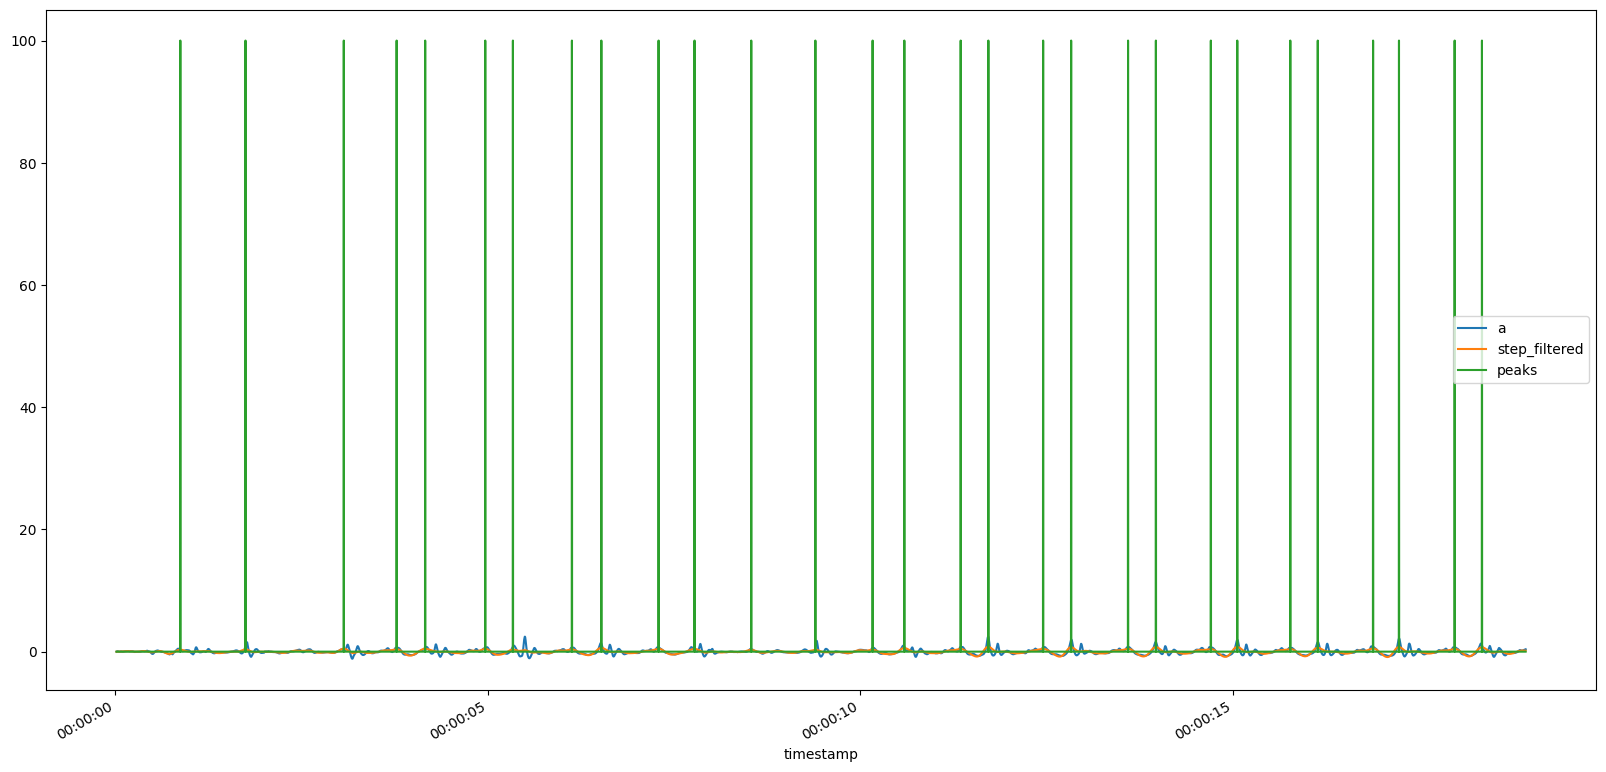

In [31]:
# peak detection
from scipy.signal import find_peaks

# ---- tunable defaults (so this cell works even if you didn't run earlier cells) ----
PEAK_HEIGHT = globals().get("PEAK_HEIGHT", 0.2)
MIN_STEP_SEPARATION_S = globals().get("MIN_STEP_SEPARATION_S", 0.3)

# FS is computed near the top when the CSV is loaded; fallback to 400 if needed
FS = globals().get("FS", fs)
MIN_PEAK_DISTANCE_SAMPLES = globals().get(
    "MIN_PEAK_DISTANCE_SAMPLES",
    max(1, int(float(FS) * float(MIN_STEP_SEPARATION_S))),
)

print(
    f"Peak tuning: height={PEAK_HEIGHT}, min_separation={MIN_STEP_SEPARATION_S}s "
    f"({MIN_PEAK_DISTANCE_SAMPLES} samples at FS≈{FS:.2f}Hz)"
)

# distance should scale with sampling rate (avoid hard-coded 20/100 samples)
peaks, _ = find_peaks(
    df['step_filtered'].values,
    height=float(PEAK_HEIGHT),
    distance=int(MIN_PEAK_DISTANCE_SAMPLES),
)

df['peaks'] = 0
df.loc[peaks, 'peaks'] = 100
df.head(8000).plot(x='timestamp', y=['a','step_filtered','peaks'], figsize=(20,10))

In [32]:
#count peaks by summing the peaks column and dividing by 100 (the value of the peaks)
df['peaks'].sum()/100


np.float64(51.0)

For this file, the expected number of steps is 257. How many steps did we find?

There is still one issue with our step counter:
4. **Bumpy Peaks**: Our pedometer should accommodate many people with different walks, so we've set minimum and maximum step frequencies based on a large sample size of people and walks. This means that we may sometimes filter slightly too much or too little. While we'll often have fairly smooth peaks, we can, once in a while, get a "bumpier" peak.

When bumpiness occurs at our threshold, we can mistakenly count too many steps for one peak. We'll use a method called hysteresis to address this. Hysteresis refers to the dependence of an output on past inputs. We can count threshold crossings in the positive direction, as well as 0 crossings in the negative direction. Then, we only count steps where a threshold crossing occurs after a 0 crossing, ensuring we count each step only once.

Let's find the time between two consecutive peaks. We will filter the dataset to only include the peaks. We will then use the diff function to calculate the difference between two consecutive timestamps.

### Implementing histeresis
We will now implement histeresis to remove the bumpy peaks. We will first identify zero crossings.
Take a look at the graph and identify a peak that doesn't follow a zero crossing.


<Axes: xlabel='timestamp'>

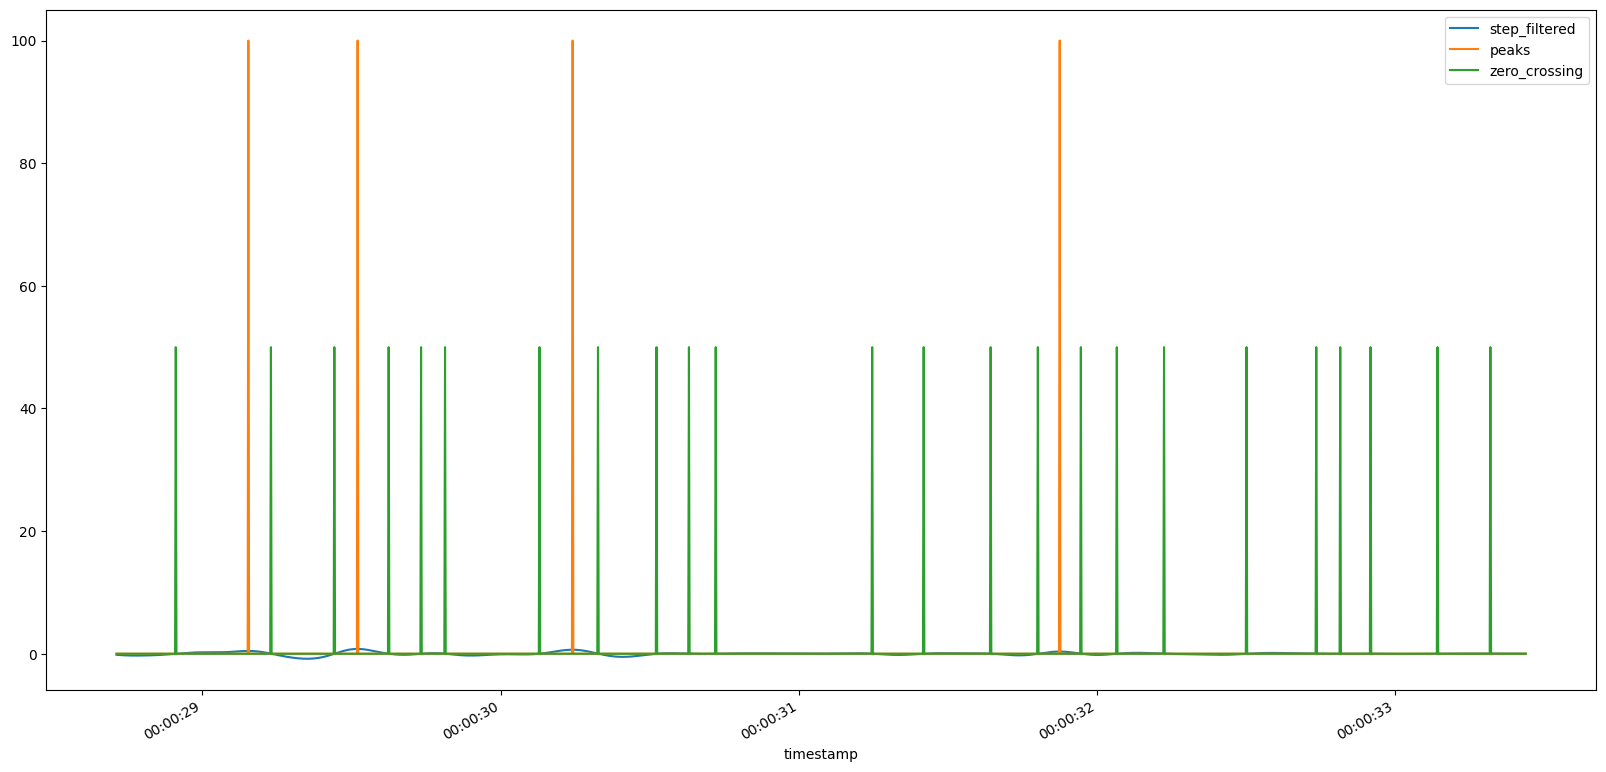

In [33]:
#find zero crossings
zero_crossings = np.where(np.diff(np.sign(df['step_filtered'].values)))[0]
df['zero_crossing'] = 0

df.loc[zero_crossings, 'zero_crossing']=50

df.tail(2000).plot(x='timestamp', y=['step_filtered','peaks', 'zero_crossing'], figsize=(20,10))

In [34]:
#filter only peaks and zero crossings
df_filtered = df[(df['peaks'] > 0) | (df['zero_crossing'] > 0)]
#Hint - Implement a logic and create a dataframe which only contains rows with positive peaks or zero crossing. [Clue- df[(df['peaks']>0)] will give us df with peaks value greater than 0]

df_filtered['value'] = df_filtered['peaks'] + df_filtered['zero_crossing']

#find 100's in the value column that do not follow a 50 (diff is 0 if a peak follows another peak)
df_filtered[(df['peaks'] > 0) & (df_filtered['value'].diff()>0)].count()


/tmp/ipython-input-3328216848.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['value'] = df_filtered['peaks'] + df_filtered['zero_crossing']
/tmp/ipython-input-3328216848.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered[(df['peaks'] > 0) & (df_filtered['value'].diff()>0)].count()


,0
timestamp,51
id,51
x,51
y,51
z,51
x_g,51
y_g,51
z_g,51
x_u,51
y_u,51


### Questions
1. What does the function np.diff do?
2. What is the meaning of the zero_crossings variable?
3. How many peaks do not follow a zero crossing?
4. How did you identify the peaks that do not follow a zero crossing?





#### Your answers go here (double click here)

1. ```np.diff``` calculates the difference between consecutive elements in an array


2. ```zero_crossings``` contains indices where the signal crosses zero (changes from positive to negative or vice versa)

3. 419 peaks do not follow a zero crossing (from the count output showing 419)

4. By checking if value.diff() > 0, meaning a peak (100) follows another peak instead of a zero crossing (50)






# Your turn
1. Play with the parameters of the step counter to make it closer to the expected value. What parameters can you change?
2. Download another file and find the number of steps from https://github.com/Oxford-step-counter/DataSet/tree/master ( Select one file and click on view raw data, use that url to download the file) THe expected number of steps is in the file "".
3. Play with the parameters of the step counter to make it closer to the expected value. What parameters can you change?
4. Collect data with your Sensor Toolkit Application for 15 to 20 steps. Record it and upload it here. Can you accurately count the steps?

Small note: earlier answers in this notebook were done using the backpocket dataset. Only this block is based on my own collected dataset.

1.  I can change the peak detection height (threshold), the minimum distance between peaks (based on sampling rate), and the bandpass filter cutoffs (low_cutoff/high_cutoff). I can also trim the recording to only the walking part.

2.  I walked 50 steps and the algorithm detected 57, so it’s fairly close. With a bit more tuning (threshold, min distance, cutoffs) it can get closer.

# Submission
In Moodle, submit:
- a text file with a link to your google colab notebook.
- Your accelerometer data for 20 steps.
- The pdf and .py files for this notebook.

Deadline: Monday Jan 26 23:59.
